## Import Libraries Modules

In [1]:
import sys
parentdir = 'C:\\Users\\Jerzy\\Documents\\GitHub\\BAMT'
sys.path.insert(0, parentdir)


In [2]:
import time
from tqdm.notebook import tqdm
from graph.precision_recall import precision_recall
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.model_selection import train_test_split

from bayesian.train_bn import structure_learning, parameter_learning
from bayesian.save_bn import save_params, save_structure, read_params, read_structure
from preprocess.discretization import get_nodes_sign
from bayesian.sampling import generate_synthetics
from external.libpgm.hybayesiannetwork import HyBayesianNetwork
from preprocess.discretization import discretization, get_nodes_type, code_categories
from visualization.visualization import draw_BN, draw_comparative_hist
from sklearn.metrics import mutual_info_score
from sklearn.feature_selection import mutual_info_regression

mpl.style.use('seaborn')
plt.rcParams.update({'font.size': 22})


## Functions to calculate possible edges

In [3]:
def get_n_nearest(data, columns, corr=False, number_close=5):
    """Returns n nearest neighbors for every column of dataframe, added into list

    Args:
        data (DataFrame): Proximity matrix
        columns (list): df.columns.tolist()
        corr (bool, optional): _description_. Defaults to False.
        number_close (int, optional): Number of nearest neighbors. Defaults to 5.

    Returns:
        groups
    """
    groups = []
    if corr:
        for c in columns:
            close_ind = data[c].sort_values(ascending=False).index.tolist()
            groups.append(close_ind[0:number_close+1])
    else:
        for c in columns:
            close_ind = data[c].sort_values().index.tolist()
            groups.append(close_ind[0:number_close+1])

    return groups


def get_proximity_matrix(df, df_coded, proximity_metric):
    """Returns matrix of mutual information score of the dataframe, dataframe must be coded first if it contains categorical data

    Args:
        df (DataFrame): data
        df_coded (DataFrame): same data, but coded
        proximity_metric (str): 'MI' or 'corr'

    Returns:
        df_distance: mutual information matrix
    """

    df_distance = pd.DataFrame(data=np.zeros(
        (len(df.columns), len(df.columns))), columns=df.columns)
    df_distance.index = df.columns

    if proximity_metric == 'MI':
        for c1 in df.columns:
            for c2 in df.columns:
                dist = mutual_info_score(
                    df_coded[c1].values, df_coded[c2].values)
                df_distance.loc[c1, c2] = dist

    elif proximity_metric == 'corr':
        df_distance = df_coded.corr(method='pearson')

    return df_distance


def get_brave_matrix(df, proximity_matrix, n_nearest=5):
    """Returns matrix Brave coeffitients of the DataFrame, requires proximity measure to be calculated

    Args:
        df (DataFrame): data
        proximity_matrix (DataFrame): might be generated by get_mutual_info_score_matrix() function or correlation from scipy
        n_nearest (int, optional): _description_. Defaults to 5.

    Returns:
        brave_matrix: DataFrame of Brave coefficients
    """

    brave_matrix = pd.DataFrame(data=np.zeros(
        (len(df.columns), len(df.columns))), columns=df.columns)
    brave_matrix.index = df.columns

    groups = get_n_nearest(proximity_matrix, df.columns.tolist(),
                           corr=True, number_close=n_nearest)

    for c1 in df.columns:
        for c2 in df.columns:
            a = .0
            b = .0
            c = .0
            d = .0
            if c1 != c2:
                for g in groups:
                    if (c1 in g) & (c2 in g):
                        a += 1
                    if (c1 in g) & (c2 not in g):
                        b += 1
                    if (c1 not in g) & (c2 in g):
                        c += 1
                    if (c1 not in g) & (c2 not in g):
                        d += 1
                br = (a * len(groups) + (a + c)*(a + b)) / ((math.sqrt((a + c) *
                                                                       (b + d))) * (math.sqrt((a + b) * (c + d))))
                brave_matrix.loc[c1, c2] = br

    return brave_matrix


def get_possible_edges_by_brave(df, proximity_matrix, n_nearest=5, custom_threshold=False, threshold=.0):
    """Returns list of possible edges for structure learning

    Args:
        df (DataFrame): data
        proximity_matrix (DataFrame): might be generated by get_mutual_info_score_matrix() function, correlation etc.
        n_nearest (int, optional): Number of Nearest neighbors, hyperparameter. Defaults to 5.
        custom_threshold (bool, optional): Must be set true to redact threshold, then set threshold. Defaults to False.
        threshold (float, optional): Threshold for edge candidates to be passed to possible edges, threshold. Defaults to 0.3 [0;1].

    Returns:
        Possible edges: list of possible edges
    """
    brave_matrix = get_brave_matrix(df, proximity_matrix, n_nearest)

    possible_edges = []

    if custom_threshold == False:
        for c1 in df.columns:
            for c2 in df.columns:
                if brave_matrix.loc[c1, c2] > brave_matrix.max(numeric_only='true').max()*0.3:
                    possible_edges.append((c1, c2))
    else:
        for c1 in df.columns:
            for c2 in df.columns:
                if brave_matrix.loc[c1, c2] > brave_matrix.max(numeric_only='true').max()*threshold:
                    possible_edges.append((c1, c2))

    return possible_edges


## Import data, code categorical data

In [4]:
df = pd.read_csv('data/medicine.csv')
df

,total_bilirubin_mean,triglycerides_mean,creatinine_mean,potassium_mean,AST_mean,ALT_mean,sodium_mean,total_protein_mean,HDL_mean,hba1c_mean,...,diabetic_angiopathy,diabetic_nephropathy,neuropathy,cushing_syndrome,stroke,insulins,all_gipoglemic_drugs,all_statins,diuretic,beta_block
0,11.738543,0.670000,137.00,4.500000,28.000000,28.000000,140.000000,67.200000,0.950000,8.667665,...,1,1,1,0,0,1,0,1,1,1
1,27.585625,1.720000,86.00,4.586997,25.500000,29.300000,140.393094,71.245188,1.250000,8.066571,...,0,0,0,0,0,0,0,1,0,1
2,25.028889,1.965000,86.00,4.412873,23.550000,31.650000,140.322773,71.333872,1.400000,7.934365,...,0,0,0,0,0,0,0,1,1,1
3,24.283750,1.806667,91.00,4.384852,21.066667,30.300000,140.850019,70.453878,1.330000,6.106401,...,0,0,0,0,0,0,0,1,1,1
4,24.173043,1.406667,96.00,4.507934,18.850000,30.800000,140.989590,69.446380,1.383333,6.106401,...,0,0,0,0,0,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
875,5.700000,0.760000,66.00,4.720000,11.600000,14.400000,142.000000,78.400000,1.280000,8.106455,...,1,0,0,0,0,0,1,1,0,0
876,6.800000,2.040000,81.00,5.290000,26.787070,31.472158,143.000000,73.600000,1.220000,10.806466,...,1,1,1,0,1,1,1,0,1,1
877,6.800000,2.040000,81.50,5.350000,27.158420,29.483380,144.500000,73.600000,1.220000,10.806466,...,1,1,1,0,1,1,1,0,1,1
878,5.220000,1.760000,80.50,5.350000,21.200000,24.700000,144.500000,75.105000,1.303333,10.381475,...,1,1,1,0,1,1,1,1,1,1


In [5]:
# df[['arterial_hypertension','essential_hypertension','CHF','COPD','atherosclerosis','anemia','APC','CKD','harmful_lifestyle','AF','IGT','metabolic_syndrome','obesity','stenocardia','sleep_disorders','DLM','hyperglycemia','diabetic_osteoarthropathy','diabetic_ulcer','thyrotoxicosis','hypocorticism','acromegaly','ischemic_cardiomyopathy','myocardial_infarction','CHD','ACS','diabetic_retinopathy','diabetic_angiopathy','diabetic_nephropathy','neuropathy','cushing_syndrome','stroke','insulins','all_gipoglemic_drugs','all_statins','diuretic','beta_block']] = df[[
#     'arterial_hypertension','essential_hypertension','CHF','COPD','atherosclerosis','anemia','APC','CKD','harmful_lifestyle','AF','IGT','metabolic_syndrome','obesity','stenocardia','sleep_disorders','DLM','hyperglycemia','diabetic_osteoarthropathy','diabetic_ulcer','thyrotoxicosis','hypocorticism','acromegaly','ischemic_cardiomyopathy','myocardial_infarction','CHD','ACS','diabetic_retinopathy','diabetic_angiopathy','diabetic_nephropathy','neuropathy','cushing_syndrome','stroke','insulins','all_gipoglemic_drugs','all_statins','diuretic','beta_block']].astype(str)


In [6]:
t = get_nodes_type(df)
t

{'total_bilirubin_mean': 'cont',
 'triglycerides_mean': 'cont',
 'creatinine_mean': 'cont',
 'potassium_mean': 'cont',
 'AST_mean': 'cont',
 'ALT_mean': 'cont',
 'sodium_mean': 'cont',
 'total_protein_mean': 'cont',
 'HDL_mean': 'cont',
 'hba1c_mean': 'cont',
 'LDL_mean': 'cont',
 'cholesterol_mean': 'cont',
 'AC_mean': 'cont',
 'hemoglobin_mean': 'cont',
 'hematocrit_mean': 'cont',
 'leukocytes_mean': 'cont',
 'CAD_mean': 'cont',
 'DAD_mean': 'cont',
 'bmi_mean': 'cont',
 'arterial_hypertension': 'disc',
 'essential_hypertension': 'disc',
 'CHF': 'disc',
 'COPD': 'disc',
 'atherosclerosis': 'disc',
 'anemia': 'disc',
 'APC': 'disc',
 'CKD': 'disc',
 'harmful_lifestyle': 'disc',
 'AF': 'disc',
 'IGT': 'disc',
 'metabolic_syndrome': 'disc',
 'obesity': 'disc',
 'stenocardia': 'disc',
 'sleep_disorders': 'disc',
 'DLM': 'disc',
 'hyperglycemia': 'disc',
 'diabetic_osteoarthropathy': 'disc',
 'diabetic_ulcer': 'disc',
 'thyrotoxicosis': 'disc',
 'hypocorticism': 'disc',
 'acromegaly': 'di

In [7]:
# df_coded, coder = code_categories(df, 'label', ['Treatment'])
# df_coded


In [8]:
structure_right = pd.read_csv(
    'data/medicine_true.csv')
sparsebn_edges = pd.read_csv(
    'data/magic-niab_sparsebn.csv')
bidag_edges = pd.read_csv(
    'data/medicine_discrete_bidag.csv')

print(structure_right, sparsebn_edges, bidag_edges)


                       V1                    V2
0          thyrotoxicosis  total_bilirubin_mean
1             all_statins  total_bilirubin_mean
2             all_statins    triglycerides_mean
3             all_statins              ALT_mean
4             all_statins              AST_mean
..                    ...                   ...
135         hyperglycemia  diabetic_nephropathy
136         hyperglycemia            neuropathy
137  diabetic_nephropathy    total_protein_mean
138  diabetic_nephropathy                   CKD
139                   CKD    total_protein_mean

[140 rows x 2 columns]           V1        V2
0   YR.GLASS  YR.FIELD
1   YR.GLASS       MIL
2   YR.GLASS      G418
3   YR.GLASS      G311
4   YR.GLASS     G1217
..       ...       ...
65     G1800     G2835
66       FUS     G1896
67     G1750  YR.GLASS
68      G524       MIL
69      G775        FT

[70 rows x 2 columns]                        V1                     V2
0    total_bilirubin_mean         potassium_mean
1  

## Experiments

Calculate SHD score of baselines

In [9]:
pr_sparsebn = precision_recall(sparsebn_edges, structure_right)['SHD']
pr_bidag = precision_recall(bidag_edges, structure_right)['SHD']

print(pr_sparsebn, pr_bidag)


206 343


In [10]:
df_discrete, _ = discretization(df, 'equal_frequency', ['total_bilirubin_mean',
                                                                  'triglycerides_mean',
                                                                  'creatinine_mean',
                                                                  'potassium_mean',
                                                                  'AST_mean',
                                                                  'ALT_mean',
                                                                  'sodium_mean',
                                                                  'total_protein_mean',
                                                                  'HDL_mean',
                                                                  'hba1c_mean',
                                                                  'LDL_mean',
                                                                  'cholesterol_mean',
                                                                  'AC_mean',
                                                                  'hemoglobin_mean',
                                                                  'hematocrit_mean',
                                                                  'leukocytes_mean',
                                                                  'CAD_mean',
                                                                  'DAD_mean',
                                                                  'bmi_mean'])
    


df_mis = get_proximity_matrix(
    df_discrete, df_discrete, proximity_metric='MI')
possible_edges = get_possible_edges_by_brave(
    df_discrete, proximity_matrix=df_mis, n_nearest=5)
bn = structure_learning(df_discrete, 'HC', get_nodes_type(
    df_discrete), 'K2', white_list=possible_edges)

In [11]:
save_structure(bn, 'st_reg')
params = parameter_learning(df, {var: 'cont' for var in bn["V"]}, bn, 'mix')
save_params(params, 'par_reg')

c:\Users\Jerzy\AppData\Local\Programs\Python\Python39\lib\site-packages\gmr\mvn.py:198: RuntimeWarning: overflow encountered in square
  exponent = -0.5 * np.sum(X_normalized ** 2, axis=1)
C:\Users\Jerzy\AppData\Roaming\Python\Python39\site-packages\sklearn\mixture\_base.py:143: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  cluster.KMeans(
C:\Users\Jerzy\AppData\Roaming\Python\Python39\site-packages\sklearn\mixture\_base.py:143: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  cluster.KMeans(
C:\Users\Jerzy\AppData\Roaming\Python\Python39\site-packages\sklearn\mixture\_base.py:143: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  cluster.KMeans(
C:\Users\Jerzy\AppData\Roaming\Python\Python39\site-packages\sklearn\mixture\_base.py:143: ConvergenceWarn

In [12]:
bn_h = HyBayesianNetwork(read_structure('st_reg'), read_params('par_reg'))
sample = generate_synthetics(bn_h, {var: 'neg' for var in bn["V"]}, "mix", 880)

In [13]:
sample.describe()

,neuropathy,ACS,sleep_disorders,APC,COPD,acromegaly,hypocorticism,cushing_syndrome,obesity,bmi_mean,...,total_protein_mean,sodium_mean,potassium_mean,creatinine_mean,CKD,hba1c_mean,leukocytes_mean,hyperglycemia,diabetic_ulcer,diabetic_osteoarthropathy
count,880.000000,880.000000,880.000000,8.800000e+02,880.000000,880.000000,880.000000,880.000000,880.000000,880.000000,...,880.000000,880.000000,880.000000,880.000000,880.000000,880.000000,880.000000,880.000000,880.000000,880.000000
mean,0.864726,0.044384,0.118040,1.000000e+00,0.646976,0.006858,0.012046,0.015753,0.927785,24.898367,...,71.560906,140.730877,4.646138,90.715909,0.128700,7.305445,7.937951,0.277523,0.063636,0.001552
std,0.370547,0.196792,0.327428,1.570343e-15,0.407002,0.067974,0.108995,0.129926,0.275363,2.884650,...,5.941368,2.733148,0.422777,29.302899,0.422288,1.194731,1.942419,0.451342,0.244243,0.137914
min,-0.104245,-0.472050,-0.869069,1.000000e+00,-0.506517,-0.201925,-0.329179,-0.349776,-0.176108,14.302602,...,55.619128,129.914211,3.232429,8.415269,-1.129227,2.157466,1.063693,-1.182719,0.000000,-0.426106
25%,0.621514,-0.090302,-0.108395,1.000000e+00,0.356655,-0.039028,-0.058689,-0.073168,0.736637,23.433705,...,67.769579,138.877953,4.358990,71.348048,-0.146927,6.469402,6.580425,-0.023993,0.000000,-0.093139
50%,0.853148,0.051952,0.118810,1.000000e+00,0.638930,0.007246,0.011245,0.012871,0.922960,24.238075,...,71.188044,140.582407,4.648431,90.559836,0.130167,7.302429,7.999041,0.288427,0.000000,0.001018
75%,1.110095,0.179799,0.323062,1.000000e+00,0.908166,0.053568,0.083123,0.103764,1.110956,25.784445,...,75.244910,142.538981,4.929069,110.874892,0.411001,8.113563,9.227374,0.585702,0.000000,0.097824
max,2.207485,0.684670,1.116719,1.000000e+00,1.916262,0.275403,0.395543,0.435822,1.888898,38.763986,...,98.257116,150.353904,6.303343,191.724219,1.423653,11.786566,14.894672,1.646533,1.000000,0.434841


In [14]:
import seaborn as sns

In [20]:
fs = 36

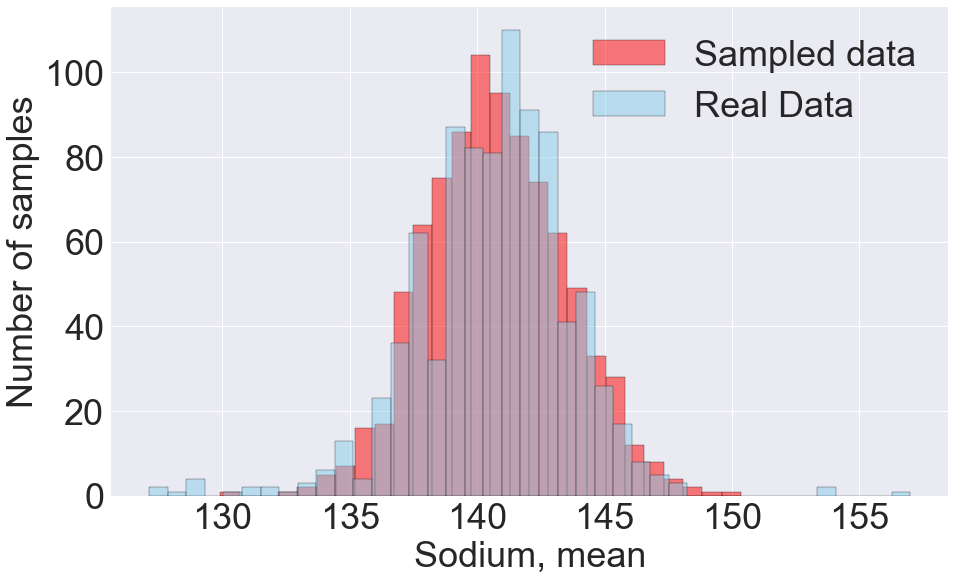

In [21]:
plt.figure(figsize=(15,9))
sns.histplot(sample['sodium_mean'], color='red', alpha=0.5, label="Sampled data")
sns.histplot(df['sodium_mean'], color='skyblue', alpha=0.5, label="Real Data")
plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)
plt.xlabel('Sodium, mean', fontsize=fs)
plt.ylabel('Number of samples', fontsize=fs)
plt.legend(fontsize=fs)

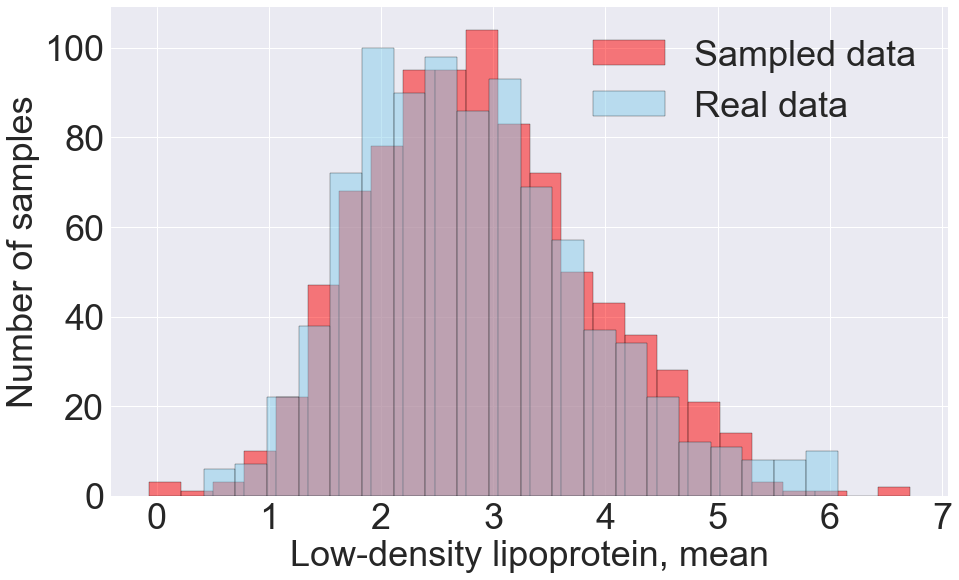

In [22]:
plt.figure(figsize=(15,9))
sns.histplot(sample['LDL_mean'], color='red', alpha=0.5, label="Sampled data")
sns.histplot(df['LDL_mean'], color='skyblue', alpha=0.5, label="Real data")
plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)
plt.xlabel('Low-density lipoprotein, mean', fontsize=fs)
plt.ylabel('Number of samples', fontsize=fs)
plt.legend(fontsize=fs)

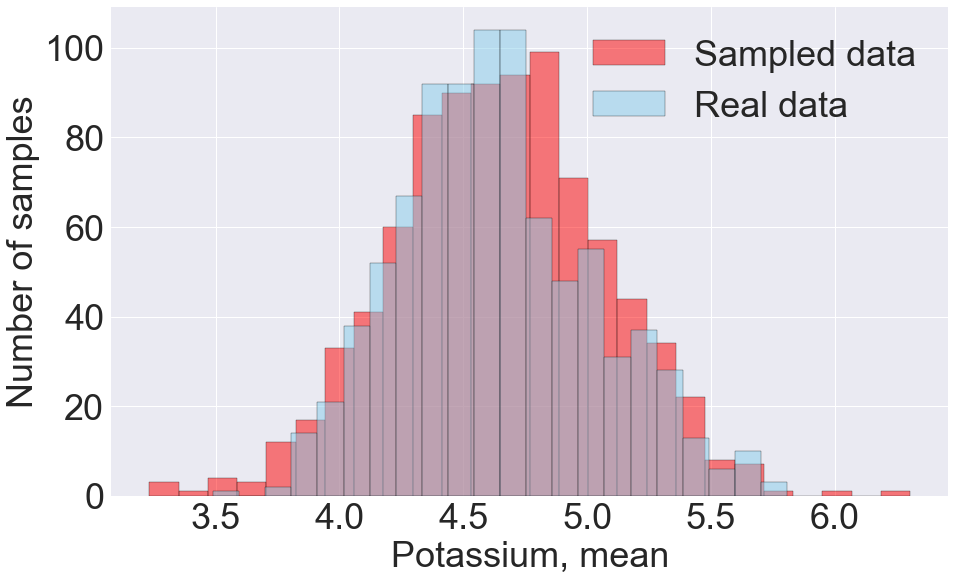

In [23]:
plt.figure(figsize=(15,9))
sns.histplot(sample['potassium_mean'].where(sample['potassium_mean']>0), color='red', alpha=0.5, label="Sampled data")
sns.histplot(df['potassium_mean'], color='skyblue', alpha=0.5, label="Real data")
plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)
plt.xlabel('Potassium, mean', fontsize=fs)
plt.ylabel('Number of samples', fontsize=fs)
plt.legend(fontsize=fs)

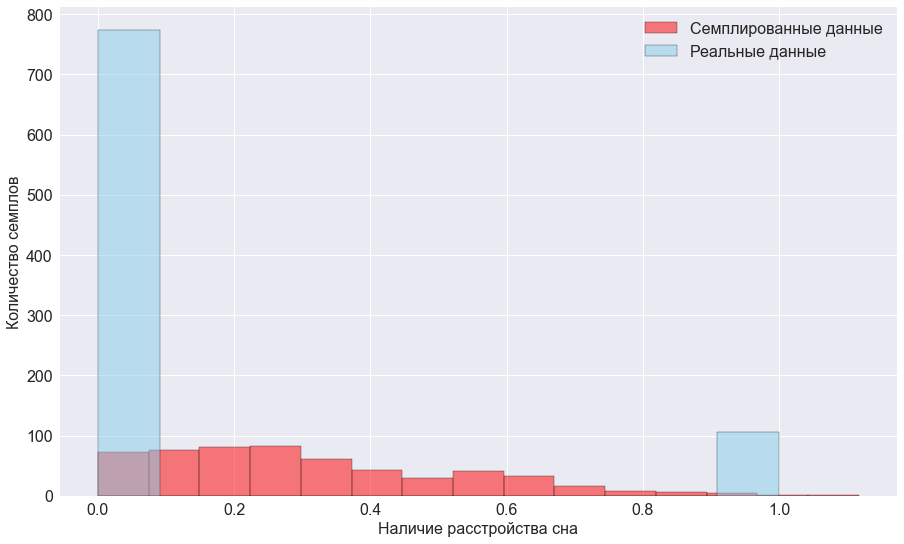

In [24]:
plt.figure(figsize=(15,9))
sns.histplot(sample['sleep_disorders'].where(sample['sleep_disorders']>0), color='red', alpha=0.5, label="Семплированные данные")
sns.histplot(df['sleep_disorders'], color='skyblue', alpha=0.5, label="Реальные данные")
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel('Наличие расстройства сна', fontsize=16)
plt.ylabel('Количество семплов', fontsize=16)
plt.legend(fontsize=16)